<a href="https://colab.research.google.com/github/IT21251900/DL-Project/blob/IT21360428/SE4050_Deep_Learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module Name: IT4010 - Research Project

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Key Objective**

The key objective of this project is to develop a machine learning model using Convolutional Neural Networks (CNN) to accurately identify diseases in chili peppers, specifically athacnose peppers and red peppers, and determine if the pepper is healthy.

**Methodology**

Supervised Learning

---



This project leverages supervised learning where the model is trained on labeled data—images of chili pepper categorized as Red peppers, Anthacnose Peppers, or Healthy. This allows the model to learn features associated with each category and make predictions on new, unseen images.

Convolutional Neural Network (CNN)

---



CNNs are well-suited for image classification tasks due to their ability to automatically detect and learn hierarchical patterns like edges, textures, and shapes in images. The model architecture consists of multiple convolutional layers, pooling layers, and fully connected layers, which help in extracting features from the potato leaf images and classifying them into one of the three categories.

Dataset

The dataset used in this project is a Chili Pepper Qulaity Idenitify Dataset, which consists of labeled images of chili peppers from three categories,

Red (Non-productive) Chili Peppers: that are not used for production level.

Anthracnose Disease Chili Peppers: that have disease in chili pepper which are not used for production.

Healthy: Chili Peppers that are not affected by any disease and are classified as healthy.

Link: https://www.kaggle.com/datasets/prudhvi143413s/anthracnose-disease-in-chili-palnadu-ap

Import all the Dependencies

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Set all the Constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

Import data into tensorflow dataset object

In [4]:
# Path to the dataset on Google Drive
dataset_path = '/content/drive/MyDrive/greeny_ml/dataset'

# Load dataset directly from Google Drive
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Verify the dataset
class_names = dataset.class_names
print("Class names:", class_names)


Found 1184 files belonging to 3 classes.
Class names: ['chilli_anthacnose', 'chilli_healthy', 'chilli_red']


In [5]:
len(dataset)

37

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 0 1 0 1 1 2 1 1 0 2 2 0 2 2 1 0 0 1 2 0 0 0 2 0 0 2 2 2 2 0]


Visualize some of the images from our dataset

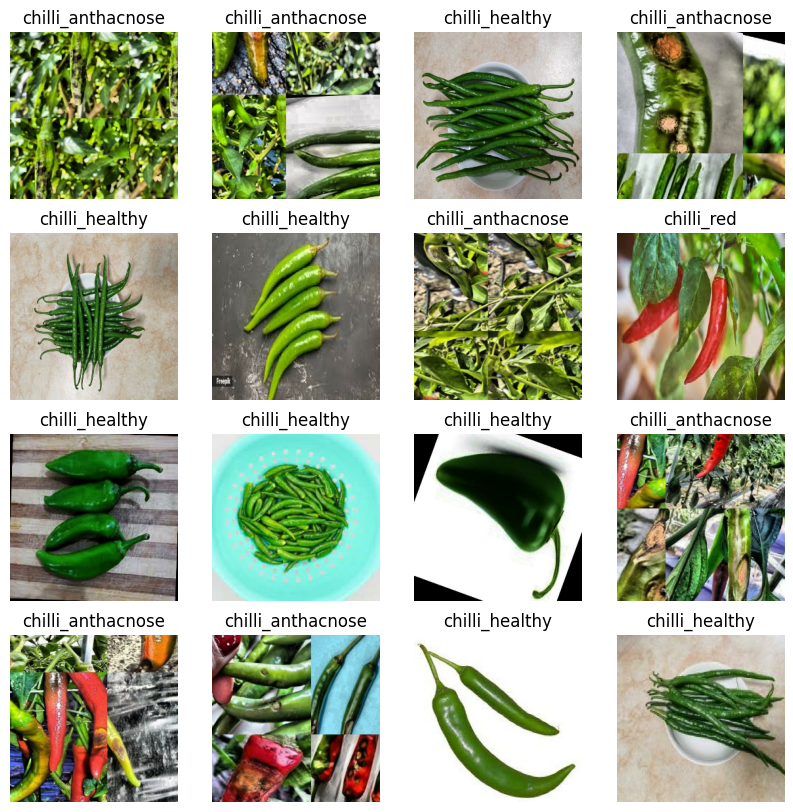

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1) # Changed the grid to 4x4 to accommodate 16 images
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely: **bold text**

Training: Dataset to be used while training
Validation: Dataset to be tested against while training
Test: Dataset to be tested against after we trained a model

In [7]:
len(dataset)

37

In [8]:
train_size = 0.8
len(dataset)*train_size

29.6

In [9]:
train_ds = dataset.take(44)
len(train_ds)

37

In [10]:
test_ds = dataset.skip(44)
len(test_ds)

0

In [11]:
val_size=0.1
len(dataset)*val_size

3.7

In [12]:
val_ds = test_ds.take(5)
len(val_ds)

0

In [13]:
test_ds = test_ds.skip(5)
len(test_ds)

0

The get_dataset_partitions_tf function partitions a TensorFlow dataset into training, validation, and test sets based on specified proportions. It accepts parameters for the split ratios (with defaults of 80% for training, 10% for validation, and 10% for testing), a shuffle flag to randomize the dataset before partitioning, and a shuffle size for the randomization buffer.

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

29

In [17]:
len(val_ds)

3

In [18]:
len(test_ds)

5

# IT21249570 - Model 01

**Dataset Caching and Prefetching**

To optimize the performance and reduce latency during training, we use caching, shuffling, and prefetching. These techniques allow us to preprocess the data while the model is training.
AUTOTUNE is used to adjust the prefetching buffer size automatically to improve efficiency.

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

###**IT21249570** - Building the Model

**Creating a Layer for Resizing and Normalization**

Before feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
], name='resize_and_rescale')

**Data Augmentation**

This boosts the accuracy of our model by augmenting the data.
It applies random transformations to the input images such as flipping them horizontally and vertically, and
rotating them by a random factor (here up to 20% of the image). By augmenting the data, we reduce overfitting,improve the model's ability to generalize, and make it more robust to variations in the input data.

In [21]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

**Applying Data Augmentation to Train Dataset**

The data augmentation layer is applied only during training (not during validation or testing) using the training=True flag.
The map function is used to apply augmentation to each image in the training dataset, maintaining their corresponding labels.

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

###**IT21249570** - Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

###### **First Conv2D Layer**
A 2D convolution layer with 32 filters, each of size 3x3. The ReLU activation function introduces non-linearity.
This layer is responsible for learning basic image features like edges and textures.
The input shape is specified as (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), matching the size and channels of the input images.


###### **Second Conv2D Layer**
Another Conv2D layer with 64 filters and 3x3 kernels. This layer learns more complex features as it builds on the previous one.
Using 64 filters allows the network to capture a higher variety of features.
.

##### **Third Conv2D Layer**
A third Conv2D layer with 64 filters and 3x3 kernels. This deeper layer captures more abstract patterns in the input images.


###### **Fourth Conv2D Layer**
A fourth Conv2D layer with 64 filters, using the same kernel size (3x3).
As the model deepens, it extracts higher-level features such as shapes and textures.

###### **Fifth Conv2D Layer**
A fifth Conv2D layer, still with 64 filters, which allows the model to capture increasingly complex features.

###### **Sixth Conv2D Layer**
A sixth Conv2D layer, again with 64 filters. This continues to deepen the model and capture advanced-level features.

###### **Flatten Layer**
The flattening layer converts the 2D feature maps into a 1D vector that can be fed into fully connected layers.
This prepares the data for the Dense (fully connected) layers.

######**First Dense Layer**
A fully connected layer with 64 units. The ReLU activation function introduces non-linearity.
This layer helps in learning combinations of the features extracted by the Conv2D layers.


In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

resize_and_rescale.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resize_and_rescale (Sequential) │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 5)                │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,877 (718.27 KB)

 Trainable params: 183,877 (718.27 KB)

 Non-trainable params: 0 (0.00 B)

###**IT21249570** - Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

**Model Training**

This section trains the CNN model on the training dataset (`train_ds`) with the specified batch size and number of epochs.
The `validation_data` parameter allows the model to evaluate its performance on the validation set (`val_ds`) after each epoch.
The `verbose=1` option provides detailed output about the training process.
The training history (loss, accuracy, etc.) will be stored in the `history` object, which can be used for further analysis or visualization.

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 263s 578ms/step - accuracy: 0.3591 - loss: 1.2765 - val_accuracy: 0.7604 - val_loss: 0.5101
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.8023 - loss: 0.4999 - val_accuracy: 0.9062 - val_loss: 0.2361
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - accuracy: 0.8900 - loss: 0.3308 - val_accuracy: 0.9271 - val_loss: 0.2180
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 372ms/step - accuracy: 0.9161 - loss: 0.2767 - val_accuracy: 0.9583 - val_loss: 0.1051
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 373ms/step - accuracy: 0.9074 - loss: 0.2071 - val_accuracy: 0.9479 - val_loss: 0.1186
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 375ms/step - accuracy: 0.8983 - loss: 0.2617 - val_accuracy: 0.9688 - val_loss: 0.0966
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 373ms/step - accuracy: 0.9043 - loss: 0.2430 - val_accuracy: 0.9583 - val_loss: 0.1255
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.9057 - loss: 0.2055 - val_acc

In [27]:
scores = model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9979 - loss: 0.0212


In [28]:
scores

[0.03367066755890846, 0.9937499761581421]

Plotting the Accuracy and Loss Curves

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 29}

In [31]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

50

In [34]:
history.history['loss'][:5]

[1.0579543113708496,
 0.49269700050354004,
 0.3293145000934601,
 0.24769729375839233,
 0.24050167202949524]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

**Plotting Training and Validation Accuracy**

The first subplot displays the training accuracy and validation accuracy over epochs.
The x-axis represents the number of epochs, while the y-axis represents accuracy values.
`acc` refers to the list of training accuracy values, and `val_acc` refers to the validation accuracy values.

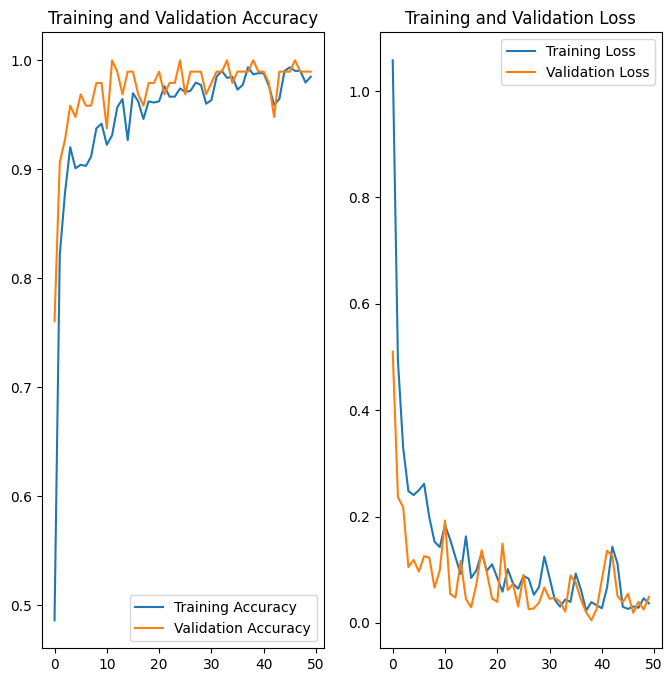

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Scatter Plot: Training vs Validation Error**

This plot visualizes the loss (error) during training and validation across different iterations (epochs).
The x-axis represents the number of epochs, while the y-axis shows the loss values.
`history.history['loss']` contains the training loss values, and `history.history['val_loss']` contains the validation loss.
The scatter plot allows easy comparison between training and validation errors to assess how well the model is generalizing.

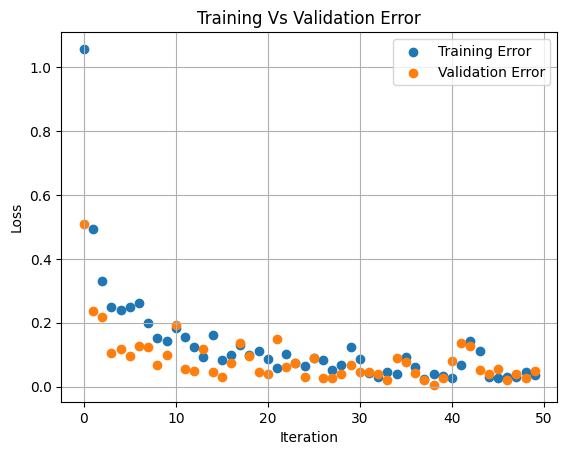

In [37]:
plt.scatter(x=history.epoch,y=history.history['loss'],label='Training Error')
plt.scatter(x=history.epoch,y=history.history['val_loss'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

Run prediction on a sample image

This code takes a batch of images from the test dataset and selects the first image and its corresponding label. It displays the image using plt.imshow() and prints its actual label. Then, the model makes predictions on the batch, and the predicted label for the first image is printed. This helps compare the model’s prediction with the actual label for that image.

First image to predict


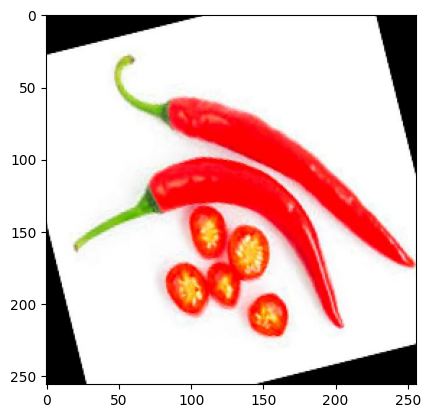

Actual label: chilli_red
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
Predicted label: chilli_red
Production suitability: Overripe or non-productive red chili peppers. These peppers are unsuitable for production due to their overripe state, which compromises quality for both processing and market standards.


In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Define the suitability mapping for 5 classes including the new 'others' class
suitability_mapping = {
    "chilli_healthy": "Healthy chili peppers. These peppers are in optimal condition and meet the standards for agricultural production or processing.",
    "chilli_red": "Overripe or non-productive red chili peppers. These peppers are unsuitable for production due to their overripe state, which compromises quality for both processing and market standards.",
    "chilli_anthracnose": "Chili peppers affected by anthracnose disease. These are unsuitable due to fungal infection (anthracnose), which affects the quality and safety of agricultural products."
}

# Assuming test_ds, model, and class_names are defined elsewhere
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[1].numpy().astype('uint8')
    first_label = labels_batch[1].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    plt.show()  # Display the image
    print("Actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    # Modify the predicted label selection based on the batch prediction
    predicted_label = class_names[np.argmax(batch_prediction[1])]

    production_status = suitability_mapping.get(predicted_label, "Unknown")

    print("Predicted label:", predicted_label)
    print("Production suitability:", production_status)


Write a function for inference

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

The following code snippet visualizes the predictions by taking a batch of images from the test dataset. It displays a 3x3 grid of images, showing the actual and predicted classes along with the confidence for each image. Each subplot presents the image, its actual label, the predicted label, and the prediction confidence percentage, providing a clear comparison of the model's performance.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


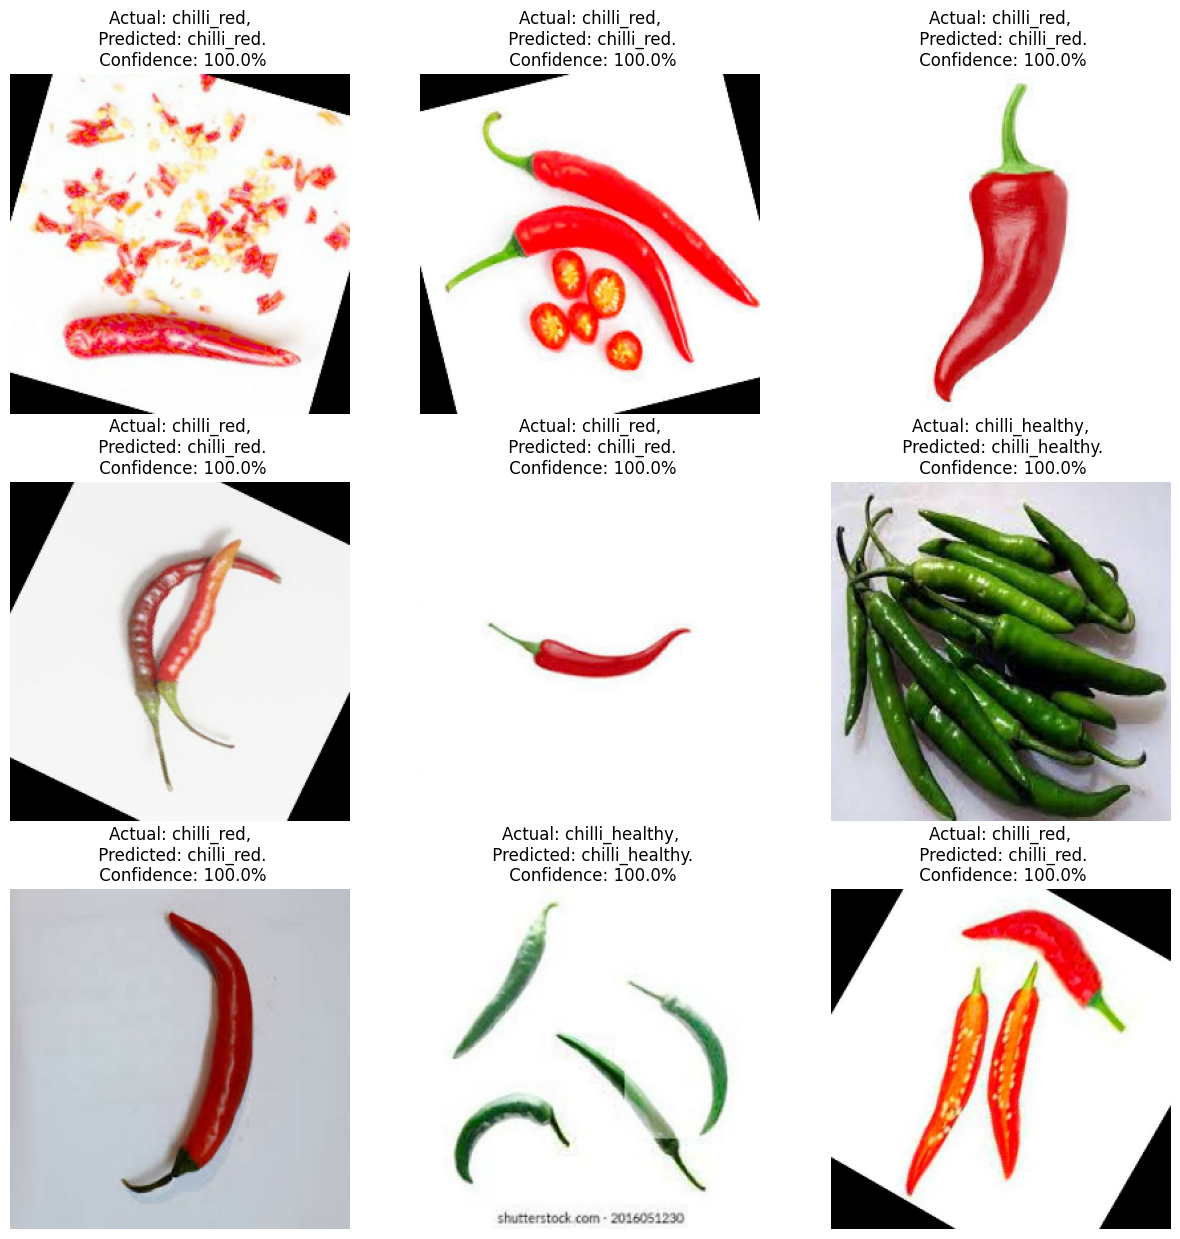

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

###**IT21249570** - Saving the Model

We append the model to the list of models as a new version

In [41]:
import os

# Define the directory in Google Drive where you want to save models
drive_models_dir = '/content/drive/MyDrive/greeny_ml/models'

# Create the directory if it doesn't exist
if not os.path.exists(drive_models_dir):
    os.makedirs(drive_models_dir)

# Extract file names without extensions and convert them to integers
model_files = [f for f in os.listdir(drive_models_dir) if f.endswith(".keras")]
model_versions = [int(f.split('.')[0]) for f in model_files if f.split('.')[0].isdigit()]

# Get the maximum model version, or default to 0 if no models exist
model_version = max(model_versions + [0]) + 1

# Save the new model with the next version number in Google Drive
model.save(f"{drive_models_dir}/{model_version}.keras")

# Also save the model with a fixed name if desired
model.save("/content/drive/MyDrive/greeny_ml/models/chili_pepper_trained_3class.keras")

# Get and print the absolute path of the saved model
model_path = os.path.abspath(f"{drive_models_dir}/{model_version}.keras")
print(f"Model saved at: {model_path}")

# Print the current working directory and check if the directory exists
print("Current Working Directory:", os.getcwd())
print("Does the models directory exist?", os.path.exists(drive_models_dir))

# List the contents of the models directory in Google Drive
!ls {drive_models_dir}


Model saved at: /content/drive/MyDrive/greeny_ml/models/2.keras
Current Working Directory: /content
Does the models directory exist? True
1.keras  2.keras  chili_pepper_trained_3class.keras  chili_pepper_trained.keras


In [42]:
import tensorflow as tf
from tensorflow.keras import metrics

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]
)


Calculates the confusion matrix based on the true and predicted labels.The code plots the confusion matrix using Seaborn's heatmap, displaying the counts of true positives, false positives, and false negatives for each class. The resulting heatmap provides a visual representation of the model's classification performance, with labeled axes for easy interpretation.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


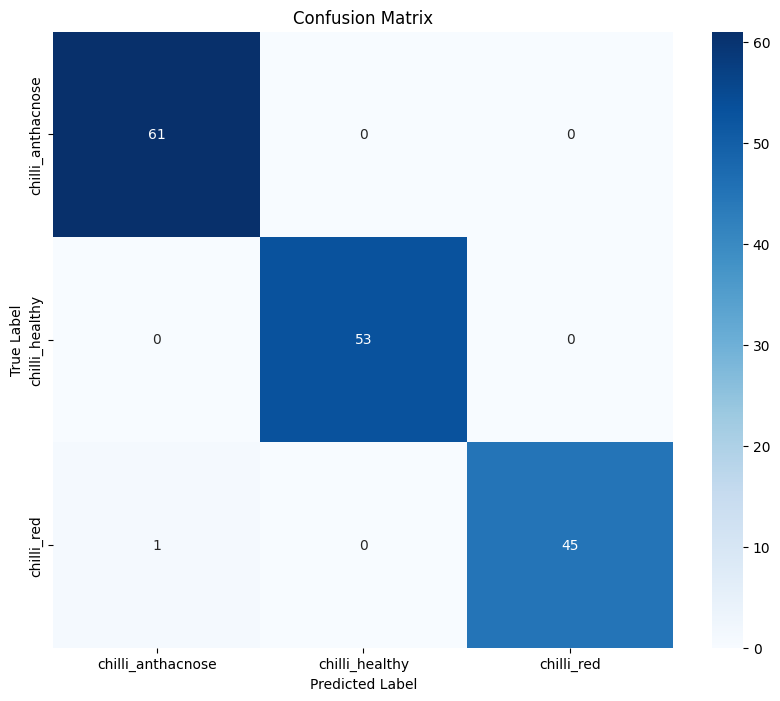

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Generate predictions on the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
